# CIFAR-10
There is a nice tutorial on image classification on the official PyTorch website: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar

Following them closely let's first reproduce their results, then try and simplify their model to see what can still work, and finally let's try to improve their model.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
net = Net()
net.to(device)

Net(
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
train_loss = []
val_loss = []

In [8]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 2.263
Test Error: 
 Val Accuracy: 25.8%, Avg val loss: 2.080327 

[2,  2000] loss: 1.673
Test Error: 
 Val Accuracy: 43.1%, Avg val loss: 1.548349 

[3,  2000] loss: 1.450
Test Error: 
 Val Accuracy: 48.8%, Avg val loss: 1.400362 

[4,  2000] loss: 1.323
Test Error: 
 Val Accuracy: 53.4%, Avg val loss: 1.287885 

[5,  2000] loss: 1.238
Test Error: 
 Val Accuracy: 55.8%, Avg val loss: 1.236262 

[6,  2000] loss: 1.164
Test Error: 
 Val Accuracy: 57.9%, Avg val loss: 1.195603 

[7,  2000] loss: 1.111
Test Error: 
 Val Accuracy: 56.6%, Avg val loss: 1.229826 

[8,  2000] loss: 1.057
Test Error: 
 Val Accuracy: 60.2%, Avg val loss: 1.131595 

[9,  2000] loss: 1.015
Test Error: 
 Val Accuracy: 60.8%, Avg val loss: 1.116296 

[10,  2000] loss: 0.972
Test Error: 
 Val Accuracy: 60.2%, Avg val loss: 1.137115 

[11,  2000] loss: 0.931
Test Error: 
 Val Accuracy: 62.9%, Avg val loss: 1.077083 

[12,  2000] loss: 0.892
Test Error: 
 Val Accuracy: 63.2%, Avg val loss: 1.066959 

[

Text(0, 0.5, 'Loss')

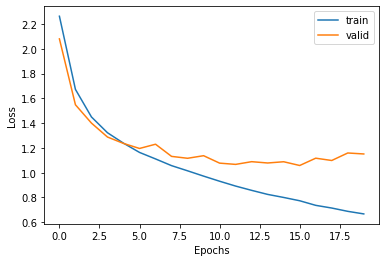

In [9]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [10]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 63.5%, Avg loss: 1.146177 



OK. It worked nicely, the model started to over-fit from epoch 15 or so.

Now let's try to simplify the Net

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.act(self.fc1(x))        
        x = self.fc2(x)
        return x

In [12]:
net = MLP()
net.to(device)

MLP(
  (act): ReLU()
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [13]:
train_loss = []
val_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 1.768
Test Error: 
 Val Accuracy: 43.2%, Avg val loss: 1.619777 

[2,  2000] loss: 1.525
Test Error: 
 Val Accuracy: 47.5%, Avg val loss: 1.502430 

[3,  2000] loss: 1.432
Test Error: 
 Val Accuracy: 48.7%, Avg val loss: 1.457228 

[4,  2000] loss: 1.357
Test Error: 
 Val Accuracy: 50.0%, Avg val loss: 1.416703 

[5,  2000] loss: 1.306
Test Error: 
 Val Accuracy: 50.4%, Avg val loss: 1.404000 

[6,  2000] loss: 1.266
Test Error: 
 Val Accuracy: 50.7%, Avg val loss: 1.402722 

[7,  2000] loss: 1.218
Test Error: 
 Val Accuracy: 51.2%, Avg val loss: 1.394588 

[8,  2000] loss: 1.189
Test Error: 
 Val Accuracy: 52.1%, Avg val loss: 1.373312 

[9,  2000] loss: 1.149
Test Error: 
 Val Accuracy: 51.7%, Avg val loss: 1.393898 

[10,  2000] loss: 1.132
Test Error: 
 Val Accuracy: 51.4%, Avg val loss: 1.400032 

[11,  2000] loss: 1.097
Test Error: 
 Val Accuracy: 52.6%, Avg val loss: 1.381729 

[12,  2000] loss: 1.073
Test Error: 
 Val Accuracy: 51.5%, Avg val loss: 1.413855 

[

Text(0, 0.5, 'Loss')

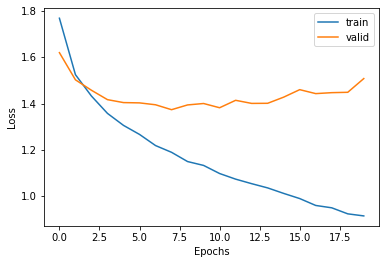

In [15]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [16]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 51.7%, Avg loss: 1.475731 



OK. Accuracy got worse - the model is much simpler but it trained. Definitely better than chance (51% vs 10% by chance). The model clearly over-fits.

Now let's see if Sigmoid activation (with the deadful gradient vanish lurking somewhere) works:

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.Sigmoid()
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.act(self.fc1(x))        
        x = self.fc2(x)
        return x

In [18]:
net = MLP()
net.to(device)

MLP(
  (act): Sigmoid()
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [19]:
train_loss = []
val_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 1.994
Test Error: 
 Val Accuracy: 34.9%, Avg val loss: 1.867804 

[2,  2000] loss: 1.796
Test Error: 
 Val Accuracy: 38.5%, Avg val loss: 1.767857 

[3,  2000] loss: 1.733
Test Error: 
 Val Accuracy: 39.4%, Avg val loss: 1.723148 

[4,  2000] loss: 1.699
Test Error: 
 Val Accuracy: 41.2%, Avg val loss: 1.696590 

[5,  2000] loss: 1.670
Test Error: 
 Val Accuracy: 41.8%, Avg val loss: 1.678390 

[6,  2000] loss: 1.647
Test Error: 
 Val Accuracy: 42.5%, Avg val loss: 1.657322 

[7,  2000] loss: 1.623
Test Error: 
 Val Accuracy: 42.4%, Avg val loss: 1.647403 

[8,  2000] loss: 1.603
Test Error: 
 Val Accuracy: 43.6%, Avg val loss: 1.624379 

[9,  2000] loss: 1.577
Test Error: 
 Val Accuracy: 44.8%, Avg val loss: 1.606991 

[10,  2000] loss: 1.558
Test Error: 
 Val Accuracy: 44.9%, Avg val loss: 1.596595 

[11,  2000] loss: 1.540
Test Error: 
 Val Accuracy: 45.2%, Avg val loss: 1.583611 

[12,  2000] loss: 1.524
Test Error: 
 Val Accuracy: 45.7%, Avg val loss: 1.577359 

[

Text(0, 0.5, 'Loss')

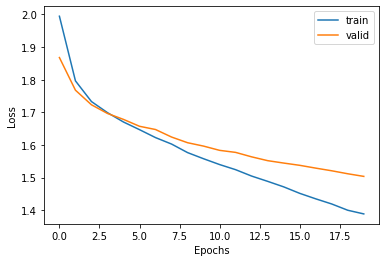

In [21]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [22]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 48.3%, Avg loss: 1.504867 



OK. Slightly worse. But the model is still training, let's run it for another 10 epochs

In [23]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 1.369
Test Error: 
 Val Accuracy: 48.5%, Avg val loss: 1.497598 

[2,  2000] loss: 1.361
Test Error: 
 Val Accuracy: 48.4%, Avg val loss: 1.495754 

[3,  2000] loss: 1.341
Test Error: 
 Val Accuracy: 48.5%, Avg val loss: 1.486527 

[4,  2000] loss: 1.330
Test Error: 
 Val Accuracy: 48.7%, Avg val loss: 1.484559 

[5,  2000] loss: 1.314
Test Error: 
 Val Accuracy: 49.1%, Avg val loss: 1.476015 

[6,  2000] loss: 1.302
Test Error: 
 Val Accuracy: 48.8%, Avg val loss: 1.475494 

[7,  2000] loss: 1.282
Test Error: 
 Val Accuracy: 49.5%, Avg val loss: 1.468043 

[8,  2000] loss: 1.278
Test Error: 
 Val Accuracy: 49.4%, Avg val loss: 1.467154 

[9,  2000] loss: 1.260
Test Error: 
 Val Accuracy: 48.9%, Avg val loss: 1.469240 

[10,  2000] loss: 1.244
Test Error: 
 Val Accuracy: 48.8%, Avg val loss: 1.467026 



In [24]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 49.6%, Avg loss: 1.456942 



Yes, the model imroved but not much. Still, Sigmoid activation was quite competitive compared to ReLU (or rather the data set is so forgiving that both models predicted the outcome better than chance)

# The crazy model

In [25]:
# without activation!
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(32*32*3, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)     
        x = self.fc2(x)
        return x

In [26]:
net = MLP()
net.to(device)

MLP(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [27]:
train_loss = []
val_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 1.835
Test Error: 
 Val Accuracy: 39.5%, Avg val loss: 1.754659 

[2,  2000] loss: 1.741
Test Error: 
 Val Accuracy: 39.7%, Avg val loss: 1.737123 

[3,  2000] loss: 1.717
Test Error: 
 Val Accuracy: 40.7%, Avg val loss: 1.723294 

[4,  2000] loss: 1.705
Test Error: 
 Val Accuracy: 40.5%, Avg val loss: 1.726440 

[5,  2000] loss: 1.696
Test Error: 
 Val Accuracy: 40.7%, Avg val loss: 1.727185 

[6,  2000] loss: 1.681
Test Error: 
 Val Accuracy: 40.6%, Avg val loss: 1.725169 

[7,  2000] loss: 1.681
Test Error: 
 Val Accuracy: 40.4%, Avg val loss: 1.719711 

[8,  2000] loss: 1.673
Test Error: 
 Val Accuracy: 40.6%, Avg val loss: 1.724313 

[9,  2000] loss: 1.673
Test Error: 
 Val Accuracy: 40.0%, Avg val loss: 1.729234 

[10,  2000] loss: 1.675
Test Error: 
 Val Accuracy: 40.6%, Avg val loss: 1.722003 



Test Error: 
 Accuracy: 40.9%, Avg loss: 1.718316 



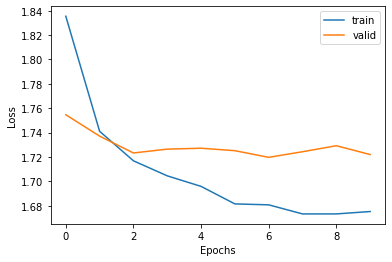

In [29]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 40.9%, Avg loss: 1.718316 



Wait, what happened? Isn't a combination of linear functions just another linear function? It is. But what trained then?

I need to step back, scratch my head and figure out that cross-entropy contains a non-linearity. So we could see that 40% accuracy is achievable without explicit activation function - and let's be honest: 40% accuracy is better than 10% or so produce by the blind chance...

## The big model

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# add some augmentation to the training data
transform_train = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


I'll describe the model a bit later, first, let's see how it works

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn0 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.cnn02 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=7, stride=1, padding=3)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.cnn03 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=9, stride=1, padding=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.act = nn.LeakyReLU(negative_slope = 0.1) 
        self.cnn11 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        self.cnn20 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn21 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.bn2 = nn.BatchNorm2d(128)
        self.cnn22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.cnn3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.cnn30 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(256 * 8 * 8, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)

    def forward(self, x):
        x0 = self.cnn0(x)
        x1 = self.cnn1(x)
        x2 = self.cnn02(x)
        x3 = self.cnn03(x)
        x = torch.cat([x1,x2], dim=1)
        x = torch.cat([x,x3], dim=1)
        x = torch.cat([x0,x], dim=1)
        x = self.bn1(x)
        x = self.act(x)
        x = self.cnn11(x)
        x = self.act(x)
        #x = torch.relu(x)
        x = self.maxpool1(x)
        
        x0 = self.cnn20(x)
        x1 = self.cnn21(x)
        x2 = self.cnn2(x)
        x = torch.cat([x1,x2], dim=1)
        x = torch.cat([x0,x], dim=1)
        x = self.bn2(x)
        x = self.act(x)
        x = self.cnn22(x)
        x = self.act(x)
        #x = torch.relu(x)
        x = self.maxpool2(x)
        x1 = self.cnn3(x)
        x2 = self.cnn30(x)
        x = torch.cat([x1,x2], dim=1)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [6]:
net = CNN()
net.to(device)

CNN(
  (cnn0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn02): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (cnn1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (cnn03): Conv2d(3, 8, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): LeakyReLU(negative_slope=0.1)
  (cnn11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn20): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn21): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (cnn2): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (m

In [7]:
train_loss = []
val_loss = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 2.123
Test Error: 
 Val Accuracy: 27.8%, Avg val loss: 1.933123 

[2,  2000] loss: 1.531
Test Error: 
 Val Accuracy: 51.8%, Avg val loss: 1.311630 

[3,  2000] loss: 1.198
Test Error: 
 Val Accuracy: 60.2%, Avg val loss: 1.103565 

[4,  2000] loss: 0.973
Test Error: 
 Val Accuracy: 68.9%, Avg val loss: 0.884504 

[5,  2000] loss: 0.833
Test Error: 
 Val Accuracy: 73.6%, Avg val loss: 0.767367 

[6,  2000] loss: 0.749
Test Error: 
 Val Accuracy: 74.9%, Avg val loss: 0.730347 

[7,  2000] loss: 0.678
Test Error: 
 Val Accuracy: 78.1%, Avg val loss: 0.647629 

[8,  2000] loss: 0.616
Test Error: 
 Val Accuracy: 79.9%, Avg val loss: 0.586506 

[9,  2000] loss: 0.574
Test Error: 
 Val Accuracy: 80.1%, Avg val loss: 0.580140 

[10,  2000] loss: 0.530
Test Error: 
 Val Accuracy: 82.2%, Avg val loss: 0.528684 



Text(0, 0.5, 'Loss')

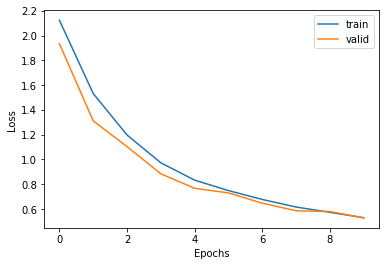

In [9]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [10]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.527600 



In [11]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 0.498
Test Error: 
 Val Accuracy: 80.7%, Avg val loss: 0.587425 

[2,  2000] loss: 0.466
Test Error: 
 Val Accuracy: 82.6%, Avg val loss: 0.515447 

[3,  2000] loss: 0.437
Test Error: 
 Val Accuracy: 84.2%, Avg val loss: 0.473307 

[4,  2000] loss: 0.417
Test Error: 
 Val Accuracy: 83.7%, Avg val loss: 0.491764 

[5,  2000] loss: 0.392
Test Error: 
 Val Accuracy: 83.8%, Avg val loss: 0.494210 

[6,  2000] loss: 0.371
Test Error: 
 Val Accuracy: 84.4%, Avg val loss: 0.492361 

[7,  2000] loss: 0.353
Test Error: 
 Val Accuracy: 84.2%, Avg val loss: 0.482377 

[8,  2000] loss: 0.336
Test Error: 
 Val Accuracy: 84.6%, Avg val loss: 0.478013 

[9,  2000] loss: 0.322
Test Error: 
 Val Accuracy: 85.2%, Avg val loss: 0.483437 

[10,  2000] loss: 0.307
Test Error: 
 Val Accuracy: 85.0%, Avg val loss: 0.482861 



Text(0, 0.5, 'Loss')

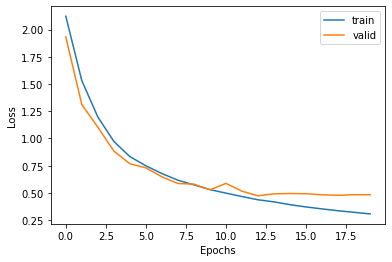

In [12]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [13]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 85.9%, Avg loss: 0.453755 



As the val.loss seems to start to level out, let's decrease the l.r.

In [14]:
optimizer = optim.SGD(net.parameters(), lr=3e-4, momentum=0.9)

In [15]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 0.210
Test Error: 
 Val Accuracy: 87.4%, Avg val loss: 0.430441 

[2,  2000] loss: 0.182
Test Error: 
 Val Accuracy: 87.5%, Avg val loss: 0.423248 

[3,  2000] loss: 0.171
Test Error: 
 Val Accuracy: 87.6%, Avg val loss: 0.427300 

[4,  2000] loss: 0.155
Test Error: 
 Val Accuracy: 88.2%, Avg val loss: 0.443976 

[5,  2000] loss: 0.146
Test Error: 
 Val Accuracy: 87.9%, Avg val loss: 0.453803 

[6,  2000] loss: 0.136
Test Error: 
 Val Accuracy: 87.5%, Avg val loss: 0.463660 

[7,  2000] loss: 0.130
Test Error: 
 Val Accuracy: 87.5%, Avg val loss: 0.474195 

[8,  2000] loss: 0.121
Test Error: 
 Val Accuracy: 87.4%, Avg val loss: 0.487839 

[9,  2000] loss: 0.115
Test Error: 
 Val Accuracy: 87.4%, Avg val loss: 0.491264 

[10,  2000] loss: 0.113
Test Error: 
 Val Accuracy: 87.7%, Avg val loss: 0.472024 



Text(0, 0.5, 'Loss')

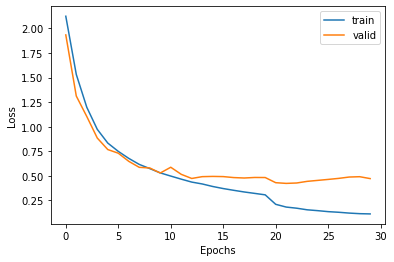

In [16]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [17]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.467160 



In [18]:
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

In [19]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            train_loss.append(running_loss / 2000)
            running_loss = 0.0
            
            size = len(testloader.dataset)
            num_batches = len(testloader)
            net.eval()
            test_loss, correct = 0, 0
            with torch.no_grad():
                for X, y in testloader:
                    X, y = X.to(device), y.to(device)
                    pred = net(X)
                    test_loss += criterion(pred, y).item()
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_loss /= num_batches
            correct /= size
            val_loss.append(test_loss)
            print(f"Test Error: \n Val Accuracy: {(100*correct):>0.1f}%, Avg val loss: {test_loss:>8f} \n")

[1,  2000] loss: 0.090
Test Error: 
 Val Accuracy: 88.3%, Avg val loss: 0.485170 

[2,  2000] loss: 0.079
Test Error: 
 Val Accuracy: 88.2%, Avg val loss: 0.500546 

[3,  2000] loss: 0.077
Test Error: 
 Val Accuracy: 88.2%, Avg val loss: 0.493050 

[4,  2000] loss: 0.075
Test Error: 
 Val Accuracy: 88.3%, Avg val loss: 0.508882 

[5,  2000] loss: 0.065
Test Error: 
 Val Accuracy: 88.2%, Avg val loss: 0.538403 

[6,  2000] loss: 0.064
Test Error: 
 Val Accuracy: 88.0%, Avg val loss: 0.539502 

[7,  2000] loss: 0.062
Test Error: 
 Val Accuracy: 88.1%, Avg val loss: 0.535369 

[8,  2000] loss: 0.061
Test Error: 
 Val Accuracy: 88.0%, Avg val loss: 0.544316 

[9,  2000] loss: 0.056
Test Error: 
 Val Accuracy: 88.2%, Avg val loss: 0.554074 

[10,  2000] loss: 0.058
Test Error: 
 Val Accuracy: 88.2%, Avg val loss: 0.562021 



Text(0, 0.5, 'Loss')

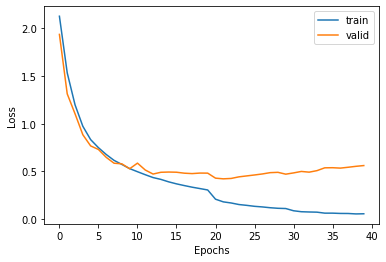

In [20]:
plt.clf()
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [21]:
# Bad practice!:
size = len(testloader.dataset)
num_batches = len(testloader)
net.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        pred = net(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.577887 



The model started to overfit from 20th epoch, so I have to be happy with 88% accuracy. Not exactly SOTA result but not bad. If the number of model's parameters is needed, let's see:

In [24]:
num_params = sum(p.numel() for p in net.parameters())
num_params

35624682